# 5 案例分析

In [1]:
import numpy as np
import pandas as pd
airline_data = pd.read_csv("../data/air_data.csv",
    encoding="gb18030") #导入航空数据
print('原始数据的形状为：',airline_data.shape)
## 去除票价为空的记录
exp1 = airline_data["SUM_YR_1"].notnull()
exp2 = airline_data["SUM_YR_2"].notnull()
exp = exp1 & exp2
airline_notnull = airline_data.loc[exp,:]
print('删除缺失记录后数据的形状为：',airline_notnull.shape)

原始数据的形状为： (62988, 44)
删除缺失记录后数据的形状为： (62299, 44)


In [2]:
#只保留票价非零的，或者平均折扣率不为0且总飞行公里数大于0的记录。
index1 = airline_notnull['SUM_YR_1'] != 0
index2 = airline_notnull['SUM_YR_2'] != 0
index3 = (airline_notnull['SEG_KM_SUM']> 0) & \
    (airline_notnull['avg_discount'] != 0)  
airline = airline_notnull[(index1 | index2) & index3]
print('删除异常记录后数据的形状为：',airline.shape)

删除异常记录后数据的形状为： (62044, 44)


In [3]:
## 选取需求特征
airline_selection = airline[["FFP_DATE","LOAD_TIME",
    "FLIGHT_COUNT","LAST_TO_END",
    "avg_discount","SEG_KM_SUM"]]
## 构建L特征
L = pd.to_datetime(airline_selection["LOAD_TIME"]) - \
pd.to_datetime(airline_selection["FFP_DATE"])
L = L.astype("str").str.split().str[0]
L = L.astype("int")/30
## 合并特征
airline_features = pd.concat([L,
    airline_selection.iloc[:,2:]],axis = 1)
print('构建的LRFMC特征前5行为：\n',airline_features.head())

构建的LRFMC特征前5行为：
            0  FLIGHT_COUNT  LAST_TO_END  avg_discount  SEG_KM_SUM
0  90.200000           210            1      0.961639      580717
1  86.566667           140            7      1.252314      293678
2  87.166667           135           11      1.254676      283712
3  68.233333            23           97      1.090870      281336
4  60.533333           152            5      0.970658      309928


In [4]:
from sklearn.preprocessing import StandardScaler
data = StandardScaler().fit_transform(airline_features)
np.savez('../tmp/airline_scale.npz',data)
print('标准化后LRFMC五个特征为：\n',data[:5,:])

标准化后LRFMC五个特征为：
 [[ 1.43571897 14.03412875 -0.94495516  1.29555058 26.76136996]
 [ 1.30716214  9.07328567 -0.9119018   2.86819902 13.1269701 ]
 [ 1.32839171  8.71893974 -0.88986623  2.88097321 12.65358345]
 [ 0.65848092  0.78159082 -0.41610151  1.99472974 12.54072306]
 [ 0.38603481  9.92371591 -0.92291959  1.3443455  13.89884778]]


In [5]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans #导入kmeans算法
airline_scale = np.load('../tmp/airline_scale.npz')['arr_0']
k = 5 ## 确定聚类中心数
#构建模型
kmeans_model = KMeans(n_clusters = k,n_jobs=4,random_state=123)

In [6]:
fit_kmeans = kmeans_model.fit(airline_scale)   #模型训练

/Users/ykkqk/anaconda2/envs/alex/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [7]:
kmeans_model.cluster_centers_ #查看聚类中心

array([[ 0.04021964, -0.23355794, -0.00268857,  2.16406805, -0.23826042],
       [-0.313024  , -0.5738834 ,  1.68723056, -0.17583135, -0.53668316],
       [ 0.48347892,  2.48295571, -0.79942816,  0.31032967,  2.42418564],
       [-0.70038846, -0.16053842, -0.41517205, -0.25863728, -0.16022805],
       [ 1.16121054, -0.08654883, -0.37738752, -0.15736817, -0.09442709]])

In [8]:
kmeans_model.labels_ #查看样本的类别标签

array([2, 2, 2, ..., 3, 1, 1], dtype=int32)

In [9]:
#统计不同类别样本的数目
r1 = pd.Series(kmeans_model.labels_).value_counts()
print('最终每个类别的数目为：\n',r1)

最终每个类别的数目为：
 3    24600
4    15726
1    12109
2     5337
0     4272
dtype: int64


In [10]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
##使用TSNE进行数据降维,降成两维
tsne = TSNE(n_components=2,init='random', random_state=177).fit(airline_scale)
df=pd.DataFrame(tsne.embedding_) ##将原始数据转换为DataFrame
df['labels'] = kmeans_model.labels_ ##将聚类结果存储进df数据表

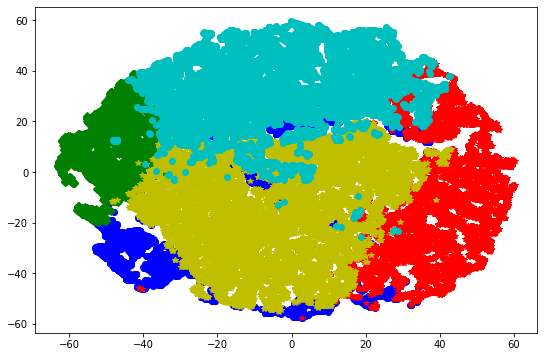

In [11]:
##提取不同标签的数据
df1 = df[df['labels']==0]
df2 = df[df['labels']==1] 
df3 = df[df['labels']==2] 
df4 = df[df['labels']==3] 
df5 = df[df['labels']==4] 
## 绘制图形
fig = plt.figure(figsize=(9,6)) ##设定空白画布，并制定大小
##用不同的颜色表示不同数据
plt.plot(df1[0],df1[1],'bo',df2[0],df2[1],'r*',
    df3[0],df3[1],'gD', df4[0],df4[1],'y*', df5[0],df5[1],'co')
plt.show() ##显示图片